In [1]:
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../../')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [2]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets data location
experiment = 'E338'
runname = '12710'

In [3]:
# Loads dataset
dataloc = '../../data/raw/' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = [1]

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

# cropping aspect ratio 
xrange = 100 
yrange = xrange


# gaussian filter parameter
hotPixThreshold = 1e3
sigma = 1
threshold = 5

In [4]:
# Extract current profiles and 2D LPS images 
xtcavImages_list = []
horz_proj_list = []
LPSImage = [] 

for a in range(len(stepsAll)):
    if len(stepsAll) == 1:
        raw_path = data_struct.images.DTOTR2.loc
    else: 
        raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = '../../data/raw/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        img_filtered = median_filter(image_cropped, size=3)
        hotPixels = img_filtered > hotPixThreshold
        img_filtered = np.ma.masked_array(img_filtered, hotPixels)
        processed_image = gaussian_filter(img_filtered, sigma=sigma, radius = 6*sigma + 1)
        processed_image[processed_image < threshold] = 0.0
        Nrows = np.array(image_cropped).shape[0]
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_cropped, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        image_ravel = image_shifted.ravel()
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)
        LPSImage.append([image_ravel])

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)
LPSImage = np.concatenate(LPSImage, axis = 0)

# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
horz_proj = horz_proj[:,DTOTR2commonind]
xtcavImages = xtcavImages[:,:,DTOTR2commonind]
LPSImage = LPSImage[DTOTR2commonind,:]

/tmp/ipykernel_958/2116267701.py:40: RuntimeWarning: invalid value encountered in divide
  centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)


In [6]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]
all_idx = np.append(minus_90_idx,plus_90_idx)

currentProfile_all = [] 

# Process all degree shots
for ij in range(len(all_idx)):
    idx = all_idx[ij]
    streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_all.append(currentProfile)
    
currentProfile_all = np.array(currentProfile_all)

In [7]:
# Filter out "bad" shots with Bi-Gaussian fit 
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

amp1 = []
R_squared = []

for ij in range(len(all_idx)):
    y = currentProfile_all[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    if xtcavPhase[all_idx][ij] < 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60 + ij*0.15, 4]
    elif xtcavPhase[all_idx][ij] > 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60, 4]
    
    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        amp1.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    amp1.append(A1)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
amp1 = np.array(amp1)
R_squared = np.array(R_squared)
goodShots = np.where((R_squared > 0.97) & (amp1 < 50))[0] # set requirements for "good" shots

/tmp/ipykernel_958/617765087.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


### MLP 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

index = np.sort(all_idx[goodShots])
images = LPSImage[all_idx,:][goodShots,:]
steps = data_struct.scalars.steps[DTOTR2commonind]
predictor = np.vstack((bsaScalarData[:,goodShots], steps[goodShots])).T

x_scaler = MinMaxScaler()
iz_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor)
Iz_scaled = iz_scaler.fit_transform(images)

# 80/20 train-test split
x_train_full, x_test_scaled, Iz_train_full, Iz_test_scaled, ntrain, ntest = train_test_split(
    x_scaled, Iz_scaled, index, test_size=0.2, random_state = 42)

# 20% validation split 
x_train_scaled, X_val, Iz_train_scaled, Y_val = train_test_split(
    x_train_full, Iz_train_full, test_size=0.2, random_state = 42)

# compress pixels 
pca = PCA(n_components=100)
compressed_targets = pca.fit_transform(Iz_train_scaled) 
Y_val = pca.transform(Y_val)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
Y_train = torch.tensor(compressed_targets, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
Y_test = torch.tensor(Iz_test_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)


In [9]:
import time

# Define MLP structure
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, out_dim)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1], Y_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss_fn = nn.L1Loss()

# Define custom weighted MSE loss function 
def custom_loss( y_pred,y_true): 
    mse = (y_true - y_pred)**2
    weights = 1 + 0.7*((y_true < 0.2)|(y_true > 0.8)).float()
    return torch.mean(weights*mse)

# Training loop 
n_epochs = 200
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0

t0 = time.time()

# Fit the nn model on the training set
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = custom_loss(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = custom_loss(val_pred, Y_val).item()
        val_losses.append(val_loss)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break
    
model.load_state_dict(best_model_state)
    
# Evaluate model
model.eval()
with torch.no_grad():
    pred_train_scaled = model(X_train).numpy()
    pred_test_scaled = model(X_test).numpy()

# Inverse transform predictions
pred_train_full = iz_scaler.inverse_transform(pca.inverse_transform(pred_train_scaled))
pred_test_full = iz_scaler.inverse_transform(pca.inverse_transform(pred_test_scaled))
Iz_train_true = iz_scaler.inverse_transform(Iz_train_scaled)
Iz_test_true = iz_scaler.inverse_transform(Iz_test_scaled)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))

# Compute R²
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

print("Train R²: {:.2f} %".format(r2_score(Iz_train_true.ravel(), pred_train_full.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(Iz_test_true.ravel(), pred_test_full.ravel()) * 100))


Elapsed time [mins] = 0.0 
Train R²: 79.80 %
Test R²: 74.64 %


In [10]:
PCA_pred = pred_test_full 

Text(0.5, 0.98, 'Test Set LPS Image: Shot 2945')

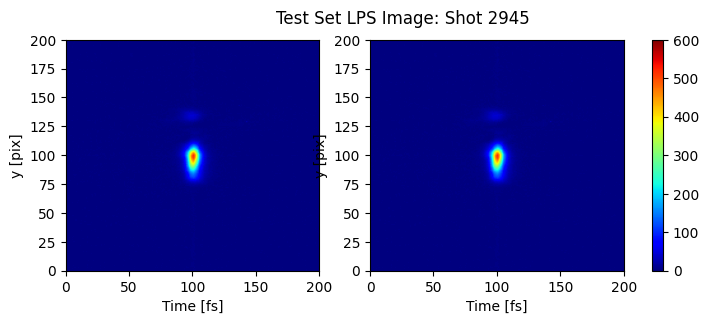

In [11]:
idx = 65
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9, 3))
im1 = ax1.imshow(pred_test_full.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto', vmin = 0, vmax = 600)
# ax1.suptitle(f"Current Profile Index: {idx}")
ax1.set(ylabel="y [pix]")
ax1.set(xlabel = "Time [fs]")
# ax1.set_title('True', fontsize = 12)
# ax1.set(title = "True", fontsize = 2)
ax1.set(xlim = (0,2*xrange))
ax1.set(ylim= (0,2*yrange))

im2 = ax2.imshow(PCA_pred.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto',vmin = 0, vmax = 600)
ax2.set(xlabel = "Time [fs]")
ax2.set(ylabel = "y [pix]")
# ax2.set_title('Prediction', fontsize = 12)
ax2.set(xlim = (0,2*xrange))
ax2.set(ylim= (0,2*yrange))
cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.16, pad=0.04)
plt.suptitle(f'Test Set LPS Image: Shot {ntest[idx]}', fontsize = 12 )


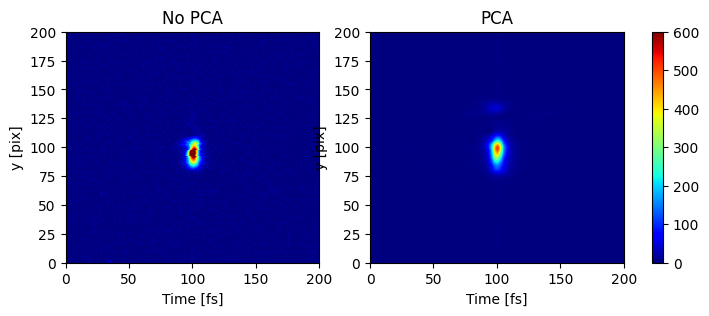

In [12]:
idx = 65
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9, 3))
im1 = ax1.imshow(Iz_test_true.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto', vmin = 0, vmax = 600)
# ax1.suptitle(f"Current Profile Index: {idx}")
ax1.set(ylabel="y [pix]")
ax1.set(xlabel = "Time [fs]")
ax1.set_title('No PCA', fontsize = 12)
# ax1.set(title = "True", fontsize = 2)
ax1.set(xlim = (0,2*xrange))
ax1.set(ylim= (0,2*yrange))

im2 = ax2.imshow(pred_test_full.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto',vmin = 0, vmax = 600)
ax2.set(xlabel = "Time [fs]")
ax2.set(ylabel = "y [pix]")
ax2.set_title('PCA', fontsize = 12)
ax2.set(xlim = (0,2*xrange))
ax2.set(ylim= (0,2*yrange))
cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.16, pad=0.04)



In [ ]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image(idx):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9, 3))
    im1 = ax1.imshow(Iz_test_true.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto', vmin = 0, vmax = 600)
   
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = "True")
    ax1.set(xlim = (0,2*xrange))
    ax1.set(ylim= (0,2*yrange))

    im2 = ax2.imshow(pred_test_full.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto',vmin = 0, vmax = 600)
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")
    ax2.set(xlim = (0,2*xrange))
    ax2.set(ylim= (0,2*yrange))
    cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    # plt.tight_layout()
    # fig.show()

# Create slider
interact(plot_xtcav_image, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

In [ ]:
streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_all.append(currentProfile)

IndentationError: unexpected indent (1995921102.py, line 3)

In [ ]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image(idx):

    horz_proj_true = np.sum(Iz_test_true.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], axis = 0)
    tvar = np.arange(1, len(horz_proj_true) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar) 
    prefactor = charge[0, ntest[idx]] / np.trapezoid(horz_proj_true, tvar) # needs to be idx from entire data set ==> manual train/test split with test_idx
    currentProfile = 1e-3 * horz_proj_true * prefactor 
    plt.plot(currentProfile, label = "True", alpha = 0.5)
    # ax1.suptitle(f"Current Profile Index: {idx}")
    plt.ylabel("y [pix]")
    plt.xlabel("Time [fs]")
    # ax1.set(xlim = (0,200))
    # ax1.set(ylim= (0,200))

    horz_proj_pred = np.sum(pred_test_full.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], axis = 0)
    prefactor = charge[0, ntest[idx]] / np.trapezoid(horz_proj_pred, tvar)
    currentProfile = 1e-3 * horz_proj_pred * prefactor 
    plt.plot(currentProfile, label = "Prediction", alpha = 0.5)
    # ax2.set(xlim = (0,200))
    # ax2.set(ylim= (0,200))
    # cbar.set_label("Current [arb. units]")
    # plt.tight_layout()
    plt.legend()
    plt.show()

# Create slider
interact(plot_xtcav_image, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=106), Output()), _dom_classes=('widget-interac…

<function __main__.plot_xtcav_image(idx)>